In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from dataclasses import dataclass, field
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Connessione a Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My\ Drive/PYTORCH/slides/Sezione\ 3/Pratica

/gdrive/.shortcut-targets-by-id/1eK5EFDQDPmk-HXdkS1PVUWdCbx1DthUN/PYTORCH/slides/Sezione 3/Pratica


### Riproducibilità

In [4]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)


### Caricamento del dataset

Carichiamo un file CSV presente in google drive.
Il dataset contiene dati di vini e la qualità, che è un intero tra 0 e 9

In [5]:
path = "datasets/winequality.csv"
df = pd.read_csv(path)
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
#Ci sono dei valori nan?
np.count_nonzero(df.isnull().values)

38

In [7]:
#Eliminiamo i valori nan
df = df.dropna()
np.count_nonzero(df.isnull().values)

0

In [8]:
#Type è una stringa, come possiamo gestirla?
df["type"].value_counts()

type
white    4870
red      1593
Name: count, dtype: int64

In [9]:
#Type deve diventare un numero (0 bianco, 1 Rosso)
df["type"] = df["type"].map(lambda x: 1 if x =="red" else 0)
df["type"].value_counts()

type
0    4870
1    1593
Name: count, dtype: int64

In [10]:
df.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,0.246480,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505
std,0.430995,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [11]:
df["quality"].value_counts()

quality
6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: count, dtype: int64

### Split in train e test

In [12]:
len(df)

6463

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[df.columns[:-1]],
                                                            pd.DataFrame(df['quality'], columns=['quality']),
                                                            test_size = 0.1, random_state=seed,
                                                            stratify=pd.DataFrame(df['quality'], columns=['quality']))
print(X_train_val.shape, y_train_val.shape)
print(X_test.shape, y_test.shape)

(5816, 12) (5816, 1)
(647, 12) (647, 1)


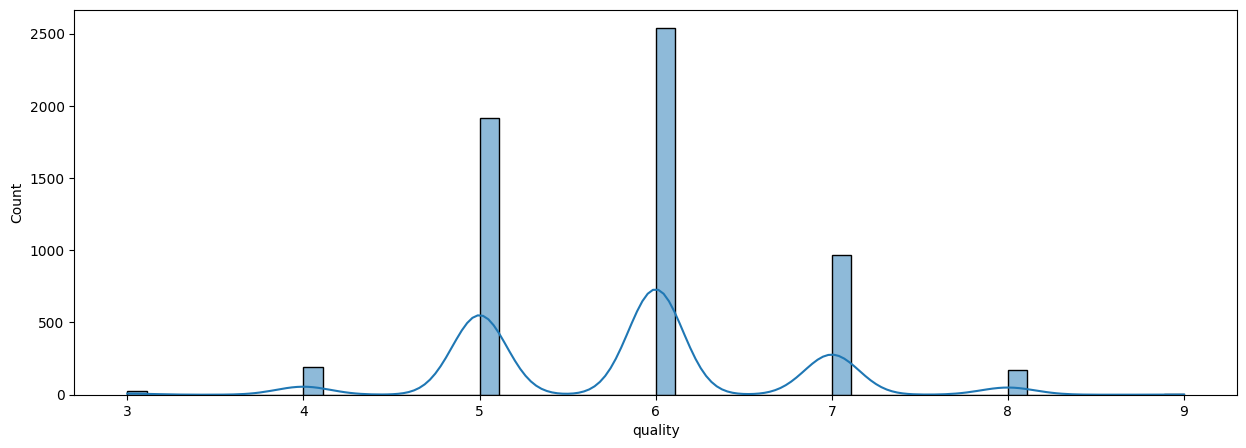

In [14]:
plt.figure(figsize=(15,5))
sns.histplot(data=y_train_val, x='quality', kde=True)
plt.show()

In [15]:
y_train_val["quality"].value_counts()

quality
6    2538
5    1915
7     966
4     193
8     173
3      27
9       4
Name: count, dtype: int64

### Normalizzazione

In [16]:
max_df = X_train_val.max()
min_df = X_train_val.min()

max_t = y_train_val.max()
min_t = y_train_val.min()

X_train_val = (X_train_val - min_df)/(max_df - min_df)
y_train_val = (y_train_val - min_t)/(max_t - min_t)

print('Input Shape',X_train_val.shape)
print('Label shape', y_train_val.shape)
X_train_val.describe()

Input Shape (5816, 12)
Label shape (5816, 1)


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000
mean,0.243810,0.281958,0.173192,0.258364,0.074418,0.102056,0.203103,0.304784,0.146002,0.385831,0.175923,0.361771
std,0.429416,0.106361,0.109828,0.116829,0.073016,0.073184,0.120102,0.156100,0.057920,0.123388,0.083703,0.172756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.214876,0.100000,0.203252,0.018405,0.063319,0.109966,0.199723,0.100058,0.302326,0.119318,0.217391
50%,0.000000,0.264463,0.140000,0.252033,0.036810,0.082969,0.192440,0.310680,0.149605,0.379845,0.159091,0.333333
75%,0.000000,0.322314,0.214167,0.317073,0.115031,0.122271,0.274914,0.416089,0.189319,0.465116,0.215909,0.478261
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


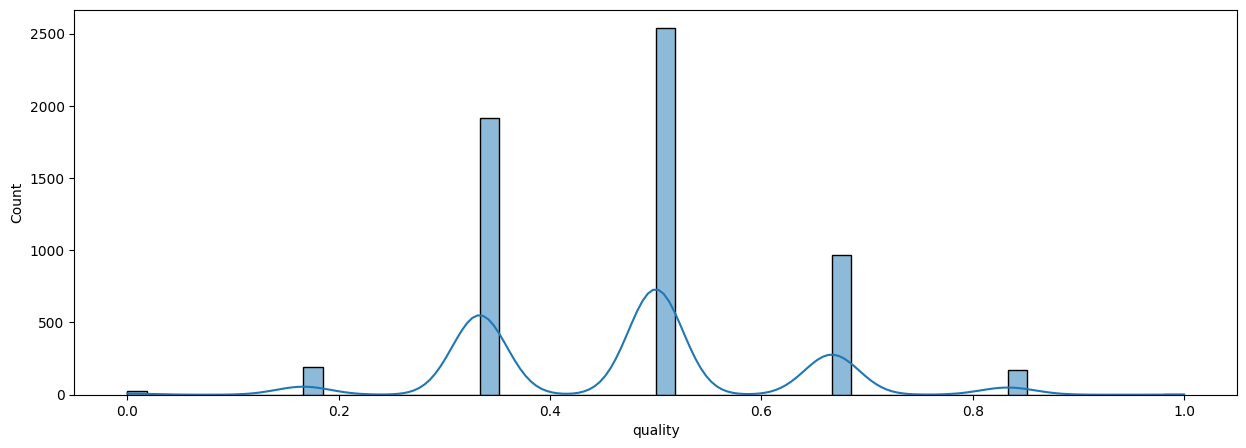

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(data=y_train_val, x='quality', kde=True)
plt.show()

In [18]:
#Applichiamo la normalizzazione al test set
X_test = (X_test - min_df)/(max_df - min_df)
y_test = (y_test - min_t)/(max_t - min_t)


### Creazione del val set


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size = len(X_test),
                                                  random_state=seed, stratify=y_train_val)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5169, 12) (5169, 1)
(647, 12) (647, 1)


In [20]:
# Reset degli indici
X_train = X_train.reset_index().drop(columns=['index'])
X_test = X_test.reset_index().drop(columns=['index'])
X_val = X_val.reset_index().drop(columns=['index'])


y_train = y_train.reset_index().drop(columns=['index'])
y_test= y_test.reset_index().drop(columns=['index'])
y_val= y_val.reset_index().drop(columns=['index'])

In [21]:
batch_size = 512

train_dataset = data_utils.TensorDataset(torch.tensor(X_train.values, dtype = torch.float32), torch.tensor(y_train.values, dtype = torch.float32))
trainloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = data_utils.TensorDataset(torch.tensor(X_val.values, dtype = torch.float32), torch.tensor(y_val.values, dtype = torch.float32))
valloader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = data_utils.TensorDataset(torch.tensor(X_test.values, dtype = torch.float32), torch.tensor(y_test.values, dtype = torch.float32))
testloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
histories = []
names = []
colors = []
val_scores = []
test_scores = []

### Baseline

Modello base, senza regolarizzazione

In [23]:
class BaselineModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=12, out_features=256)
    self.layer_2 = nn.Linear(in_features=256, out_features=128)
    self.layer_3 = nn.Linear(in_features=128, out_features=64)
    self.layer_4 = nn.Linear(in_features=64, out_features=1)

  def forward(self,x): # [256, 12]
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = F.relu(self.layer_3(x))
    x = self.layer_4(x) #[256, 1]
    return x

In [24]:
baseline = BaselineModel()

In [25]:
# Loss function
loss_fn = nn.MSELoss() # siamo in un problema di regressione

# Adam optimizer
optimizer = torch.optim.Adam(params=baseline.parameters(),
                            lr=1e-3)

epochs = 1000
train_loss_values = []
val_loss_values = []
epoch_count = []

In [26]:
for epoch in range(epochs):
    baseline.train()
    loss_epoch = 0
    for i, data in enumerate(trainloader, 0):
      X = data[0] #[256 ,12]
      y = data[1] #[256 ,1]
      y_pred = baseline(X) #[256 ,1]
      loss = loss_fn(y_pred, y)

      loss_epoch += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
    loss_val = 0
    baseline.eval()
    for j, data in enumerate(valloader, 0):

      X = data[0]
      y = data[1]

      with torch.no_grad():

        y_pred = baseline(X)
        loss = loss_fn(y_pred, y)

      loss_val += loss
    epoch_count.append(epoch)
    train_loss_values.append(loss_epoch.detach().numpy()/len(trainloader))
    val_loss_values.append(loss_val.detach().numpy()/len(valloader))
    print(f"Epoca: {epoch} |  Train Loss: {loss_epoch/len(trainloader)} | Val Loss: {loss_val/len(valloader)} ")

Epoca: 0 |  Train Loss: 0.10867774486541748 | Val Loss: 0.030068695545196533 
Epoca: 1 |  Train Loss: 0.03089533932507038 | Val Loss: 0.022726748138666153 
Epoca: 2 |  Train Loss: 0.021845851093530655 | Val Loss: 0.019650626927614212 
Epoca: 3 |  Train Loss: 0.019764555618166924 | Val Loss: 0.018630411475896835 
Epoca: 4 |  Train Loss: 0.018237007781863213 | Val Loss: 0.017627421766519547 
Epoca: 5 |  Train Loss: 0.016996799036860466 | Val Loss: 0.01676255837082863 
Epoca: 6 |  Train Loss: 0.016964800655841827 | Val Loss: 0.015855761244893074 
Epoca: 7 |  Train Loss: 0.01597590185701847 | Val Loss: 0.015366003848612309 
Epoca: 8 |  Train Loss: 0.015807239338755608 | Val Loss: 0.015217764303088188 
Epoca: 9 |  Train Loss: 0.015961240977048874 | Val Loss: 0.014762623235583305 
Epoca: 10 |  Train Loss: 0.014912951737642288 | Val Loss: 0.01462021004408598 
Epoca: 11 |  Train Loss: 0.01487984973937273 | Val Loss: 0.014597569592297077 
Epoca: 12 |  Train Loss: 0.014667722396552563 | Val Loss

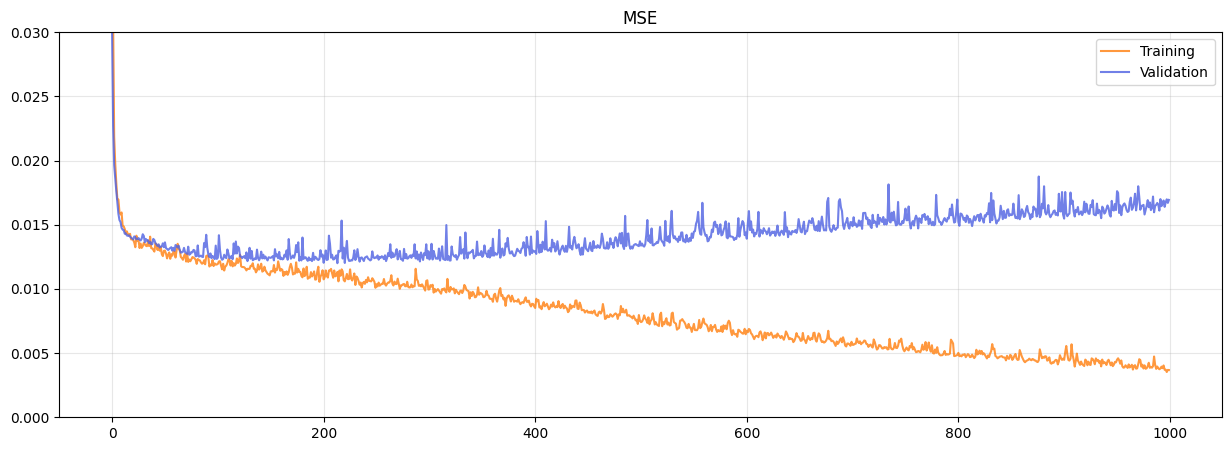

In [27]:
plt.figure(figsize=(15,5))
plt.plot(train_loss_values, label='Training', alpha=.8, color='#ff7f0e')
plt.plot(val_loss_values, label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.03)
plt.title('MSE')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

Salvataggio e caricamento modello

In [28]:
baseline_save_folder = "models/baseline/"
os.makedirs(baseline_save_folder, exist_ok = True)
baseline_save_file = os.path.join(baseline_save_folder,"model.pt")
torch.save(baseline.state_dict(), baseline_save_file)
baseline.load_state_dict(torch.load(baseline_save_file))


<All keys matched successfully>

In [29]:
print(baseline.state_dict())

OrderedDict([('layer_1.weight', tensor([[ 0.2009,  0.2514, -0.2372,  ..., -0.2182,  0.3014,  0.0111],
        [ 0.1583,  0.1145,  0.1422,  ..., -0.2009, -0.2868,  0.3166],
        [-0.2595, -0.0196, -0.0622,  ...,  0.1125, -0.1531,  0.3296],
        ...,
        [-0.0113,  0.0107, -0.1672,  ...,  0.2872,  0.2770,  0.1254],
        [-0.0465, -0.2766,  0.0387,  ..., -0.2023, -0.3981,  0.2203],
        [ 0.1199,  0.2713, -0.3680,  ...,  0.1618, -0.0907,  0.1271]])), ('layer_1.bias', tensor([-0.1117, -0.0542, -0.0762, -0.2323, -0.0457,  0.1380, -0.0325, -0.1322,
         0.0310,  0.0527, -0.0865, -0.2239, -0.1640, -0.0819,  0.1111,  0.2088,
        -0.0223,  0.1185,  0.0800, -0.1259, -0.0958,  0.0915,  0.1298,  0.0867,
        -0.2231,  0.1202, -0.1936,  0.1396,  0.0657,  0.0190, -0.2814, -0.1139,
         0.1300,  0.2331, -0.1076,  0.2142, -0.1101, -0.1698, -0.1250, -0.0022,
        -0.0788,  0.1130, -0.1598, -0.0902, -0.2861,  0.1248, -0.0988, -0.2276,
        -0.0124, -0.0795,  0.0588, 

### Early Stopping

Nel grafico precedente vediamo un chiaro esempio di Overfitting..

Possiamo usare early stopping per trovare un numero ottimale di epoche.

Per fare questo è necessario salvare un checkpoint del modello ogni volta che migliora, e non salvarlo quando peggiore, per poter ripristinare il modello migliore dopo il training.

In [32]:
early_stopping_save_folder = "models/early_stopping"
os.makedirs(early_stopping_save_folder, exist_ok = True)
early_stopping_save_file = os.path.join(early_stopping_save_folder,"model.pt")

Creiamo una classe per gestire early stopping

In [33]:
class EarlyStopping:
    def __init__(self, save_path, patience=5, min_delta=0):

        self.save_path = save_path
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss, model):

        if self.min_val_loss is None:     #Prima epoca
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)

        elif (self.min_val_loss - validation_loss) > self.min_delta: #Epoca con miglioramento
          self.min_val_loss = validation_loss
          self.save_checkpoint(model)
          self.counter = 0


        else:     #Nessun miglioramento
          self.counter +=1
          if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
      torch.save(model.state_dict(), self.save_path)



In [34]:
torch.manual_seed(seed)
# Modello con Early stopping
early_stopping_model = BaselineModel()
# Loss function
loss_fn = nn.MSELoss() # siamo in un problema di regressione

# Adam optimizer
optimizer = torch.optim.Adam(params=early_stopping_model.parameters(),
                            lr=1e-3)

early_stopping = EarlyStopping(early_stopping_save_file, patience=50, min_delta=0)

epochs = 1000
train_loss_values_early_stopping = []
val_loss_values_early_stopping = []
epoch_count_early_stopping = []

In [35]:
for epoch in range(epochs):
    early_stopping_model.train()
    loss_epoch = 0
    for i, data in enumerate(trainloader, 0):
      X = data[0]
      y = data[1]
      y_pred = early_stopping_model(X)
      loss = loss_fn(y_pred, y)

      loss_epoch += loss

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
    loss_val = 0
    early_stopping_model.eval()
    for j, data in enumerate(valloader, 0):

      X = data[0]
      y = data[1]

      with torch.no_grad():

        y_pred = early_stopping_model(X)
        loss = loss_fn(y_pred, y)

      loss_val += loss
    epoch_count_early_stopping.append(epoch)
    train_loss_values_early_stopping.append(loss_epoch.detach().numpy()/len(trainloader))
    val_loss_values_early_stopping.append(loss_val.detach().numpy()/len(valloader))


    print(f"Epoca: {epoch} |  Train Loss: {loss_epoch/len(trainloader)} | Val Loss: {loss_val/len(valloader)} ")

    early_stopping(loss_val/len(valloader), early_stopping_model)
    if early_stopping.early_stop:
      print("Early stopping all'epoca:", epoch)
      break

Epoca: 0 |  Train Loss: 0.10867774486541748 | Val Loss: 0.030068695545196533 
Epoca: 1 |  Train Loss: 0.03089533932507038 | Val Loss: 0.022726748138666153 
Epoca: 2 |  Train Loss: 0.021845851093530655 | Val Loss: 0.019650626927614212 
Epoca: 3 |  Train Loss: 0.019764555618166924 | Val Loss: 0.018630411475896835 
Epoca: 4 |  Train Loss: 0.018237007781863213 | Val Loss: 0.017627421766519547 
Epoca: 5 |  Train Loss: 0.016996799036860466 | Val Loss: 0.01676255837082863 
Epoca: 6 |  Train Loss: 0.016964800655841827 | Val Loss: 0.015855761244893074 
Epoca: 7 |  Train Loss: 0.01597590185701847 | Val Loss: 0.015366003848612309 
Epoca: 8 |  Train Loss: 0.015807239338755608 | Val Loss: 0.015217764303088188 
Epoca: 9 |  Train Loss: 0.015961240977048874 | Val Loss: 0.014762623235583305 
Epoca: 10 |  Train Loss: 0.014912951737642288 | Val Loss: 0.01462021004408598 
Epoca: 11 |  Train Loss: 0.01487984973937273 | Val Loss: 0.014597569592297077 
Epoca: 12 |  Train Loss: 0.014667722396552563 | Val Loss

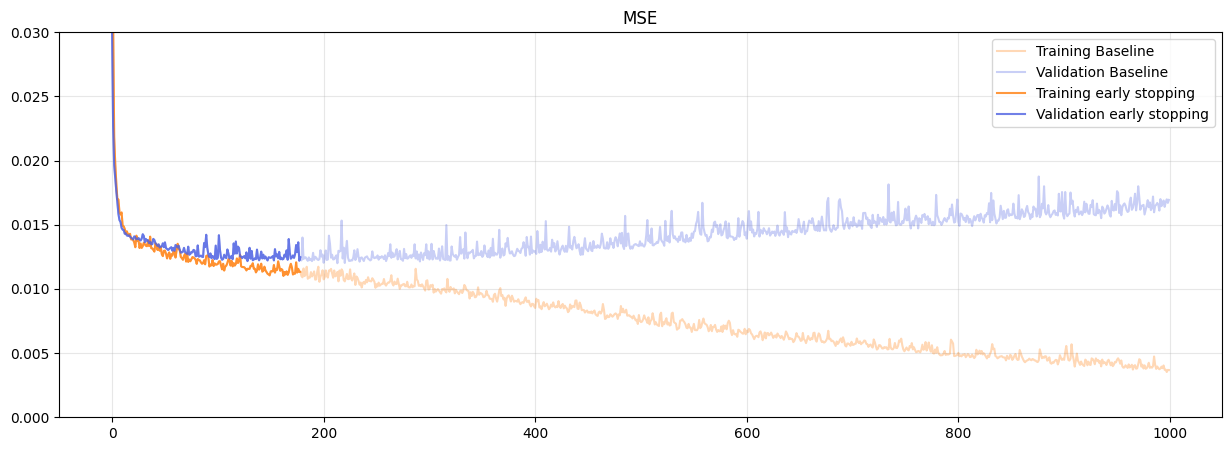

In [36]:
plt.figure(figsize=(15,5))
plt.plot(train_loss_values, label='Training Baseline', alpha=.3, color='#ff7f0e')
plt.plot(val_loss_values, label='Validation Baseline', alpha=.3, color='#4D61E2')
plt.plot(train_loss_values_early_stopping, label='Training early stopping', alpha=.8, color='#ff7f0e')
plt.plot(val_loss_values_early_stopping, label='Validation early stopping', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.03)
plt.title('MSE')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

Ripristiniamo il modello migliore

In [37]:
early_stopping_model.load_state_dict(torch.load(early_stopping_save_file))


<All keys matched successfully>

### Regolarizzazione
Introduciamo ora degli strumenti di Regolarizzazione per migliorare ulteriormente le performance.

Il numero di esperimenti inizia a crescere, cerchiamo quindi di essere più modulari e di riutilizzare il codice il più possibile.


In [41]:
@dataclass
class Experiment:
  "Questa classe rappresenta tutti gli hyperparameters e il modello di ogni esperimento"
  name: str
  checkpoints_folder: str
  checkpoint_name:str
  model: object
  use_early_stopping: bool
  loss_fn : object
  optimizer: object
  color: str
  alpha: float
  val_mse: float = None
  lr: float = 1e-5
  epochs: int = 600
  patience: int = 10
  min_delta: float = 0
  epoch_count: list = field(default_factory=list)
  val_loss_values: list = field(default_factory=list)
  train_loss_values: list = field(default_factory=list)
  plt_args_training: dict = field(default_factory=dict)
  plt_args_validation: dict = field(default_factory=dict)


  def __post_init__(self):
    self.optimizer = self.optimizer(params=self.model.parameters(),
                            lr=self.lr)
    self.checkpoints_folder = os.path.join(self.checkpoints_folder, self.name)
    os.makedirs(self.checkpoints_folder, exist_ok = True)
    self.checkpoint_save_path = os.path.join(self.checkpoints_folder, self.checkpoint_name)


In [40]:
def train_experiment(exp:Experiment, trainloader, valloader):
  exp.epoch_count = []
  exp.train_loss_values = []
  exp.val_loss_values = []
  if exp.use_early_stopping:
    early_stopping = EarlyStopping(exp.checkpoint_save_path, patience=exp.patience, min_delta=exp.min_delta)
  for epoch in range(exp.epochs):
    exp.model.train()
    loss_epoch = 0
    for i, data in enumerate(trainloader, 0):
      X = data[0]
      y = data[1]
      y_pred = exp.model(X)
      loss = exp.loss_fn(y_pred, y)

      loss_epoch += loss

      exp.optimizer.zero_grad()

      loss.backward()

      exp.optimizer.step()
    loss_val = 0
    exp.model.eval()
    for j, data in enumerate(valloader, 0):

      X = data[0]
      y = data[1]

      with torch.no_grad():

        y_pred = exp.model(X)
        loss = exp.loss_fn(y_pred, y)

      loss_val += loss
    exp.epoch_count.append(epoch)
    exp.train_loss_values.append(loss_epoch.detach().numpy()/len(trainloader))
    exp.val_loss_values.append(loss_val.detach().numpy()/len(valloader))


    print(f"Epoca: {epoch} |  Train Loss: {loss_epoch/len(trainloader)} | Val Loss: {loss_val/len(valloader)} ")

    if exp.use_early_stopping:
      early_stopping(loss_val/len(valloader), exp.model)
      if early_stopping.early_stop:
        print("Early stopping all'epoca:", epoch)
        break
  exp.model.load_state_dict(torch.load(exp.checkpoint_save_path))


In [39]:
def test_experiment(exp:Experiment, testloader):
  tot_loss = 0
  exp.model.eval()
  for j, data in enumerate(testloader, 0):

    X = data[0]
    y = data[1]

    with torch.no_grad():

      y_pred = exp.model(X)
      loss = exp.loss_fn(y_pred, y)

    tot_loss += loss
  return tot_loss.detach().numpy()/len(testloader)


Creiamo un array degli esperimenti già eseguiti e salviamo quelli già eseguiti

In [42]:
experiments = []

In [43]:
baseline_exp = Experiment(
  name = "baseline",
  checkpoints_folder = 'models',
  checkpoint_name = "model.pt",
  model = baseline,
  use_early_stopping = False,
  loss_fn = nn.MSELoss(),
  optimizer= torch.optim.Adam,
  lr = 1e-3,
  epochs = 1000,
  epoch_count =  epoch_count,
  val_loss_values = val_loss_values,
  train_loss_values =  train_loss_values,
  color = "#FF7F0E",
  alpha = .3,
)
experiments.append(baseline_exp)

In [44]:
early_stopping_exp = Experiment(
  name = "early_stopping",
  checkpoints_folder = 'models',
  checkpoint_name = "model.pt",
  model = early_stopping_model,
  use_early_stopping = True,
  loss_fn = nn.MSELoss(),
  optimizer= torch.optim.Adam,
  lr = 1e-3,
  epochs = 1000,
  patience = 50,
  epoch_count =  epoch_count_early_stopping,
  val_loss_values = val_loss_values_early_stopping,
  train_loss_values =  train_loss_values_early_stopping,
  color = "#4D61E2",
  alpha = .8
)
experiments.append(early_stopping_exp)

### Dropout Model

In [45]:
class DropoutModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=12, out_features=256)
    self.dropout_1 = nn.Dropout(p =0.4)
    self.layer_2 = nn.Linear(in_features=256, out_features=128)
    self.dropout_2 = nn.Dropout(p =0.4)
    self.layer_3 = nn.Linear(in_features=128, out_features=64)
    self.dropout_3 = nn.Dropout(p =0.4)
    self.layer_4 = nn.Linear(in_features=64, out_features=1)

  def forward(self,x): #[256 ,12]
    x = F.relu(self.layer_1(x))
    x = self.dropout_1(x)
    x = F.relu(self.layer_2(x))
    x = self.dropout_2(x)
    x = F.relu(self.layer_3(x))
    x = self.dropout_3(x)
    x = self.layer_4(x) #[256, 1]
    return x

In [47]:
torch.manual_seed(seed)
dropout_exp = Experiment(
  name = "dropout",
  checkpoints_folder = 'models',
  checkpoint_name = "model.pt",
  model = DropoutModel(),
  use_early_stopping = True,
  loss_fn = nn.MSELoss(),
  optimizer= torch.optim.Adam,
  lr = 1e-3,
  epochs = 1000,
  patience = 50,
  alpha = 0.8,
  color = "#B951D0"
)

In [48]:
train_experiment(dropout_exp, trainloader, valloader)

Epoca: 0 |  Train Loss: 0.10970649123191833 | Val Loss: 0.038428470492362976 
Epoca: 1 |  Train Loss: 0.043111447244882584 | Val Loss: 0.03378046303987503 
Epoca: 2 |  Train Loss: 0.034482136368751526 | Val Loss: 0.018792659044265747 
Epoca: 3 |  Train Loss: 0.03192133456468582 | Val Loss: 0.021002959460020065 
Epoca: 4 |  Train Loss: 0.028298521414399147 | Val Loss: 0.01799030229449272 
Epoca: 5 |  Train Loss: 0.02809961326420307 | Val Loss: 0.017444826662540436 
Epoca: 6 |  Train Loss: 0.02654520981013775 | Val Loss: 0.016731783747673035 
Epoca: 7 |  Train Loss: 0.025308402255177498 | Val Loss: 0.017509501427412033 
Epoca: 8 |  Train Loss: 0.024612480774521828 | Val Loss: 0.016637006774544716 
Epoca: 9 |  Train Loss: 0.02442176826298237 | Val Loss: 0.01652473583817482 
Epoca: 10 |  Train Loss: 0.022363999858498573 | Val Loss: 0.016506444662809372 
Epoca: 11 |  Train Loss: 0.022585632279515266 | Val Loss: 0.016247734427452087 
Epoca: 12 |  Train Loss: 0.0232065599411726 | Val Loss: 0.

In [49]:
experiments.append(dropout_exp)

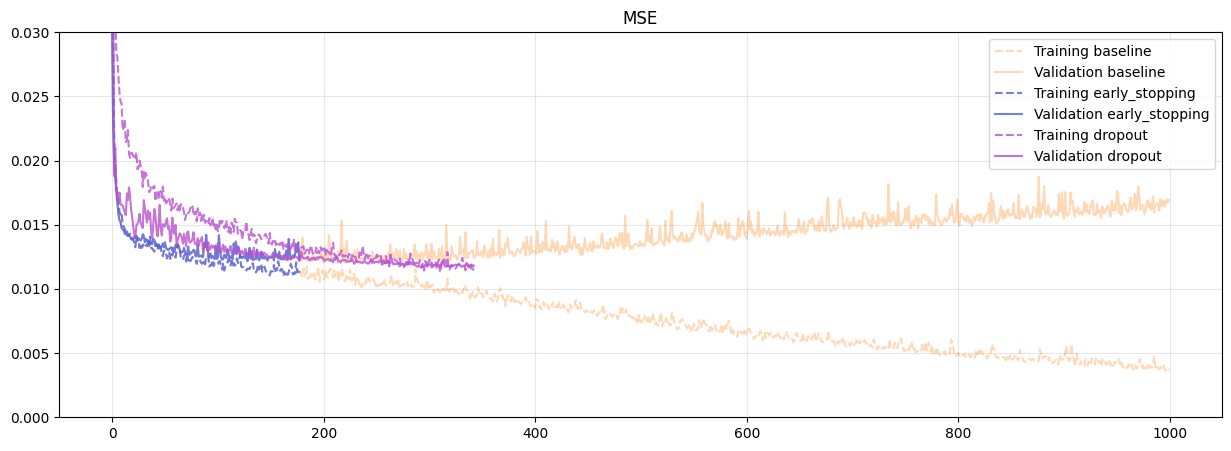

In [50]:

plt.figure(figsize=(15,5))
for i, exp in enumerate(experiments):
  plt.plot(exp.train_loss_values, label = f"Training {exp.name}", linestyle = '--', color = exp.color, alpha = exp.alpha)
  plt.plot(exp.val_loss_values, label = f"Validation {exp.name}", color = exp.color, alpha = exp.alpha)
plt.ylim(0, 0.03)
plt.title('MSE')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [51]:
for exp in experiments:
  exp.val_mse = test_experiment(exp, valloader)

In [52]:
list(map(lambda x: f"Exp {x.name}: MSE {x.val_mse}", experiments))

['Exp baseline: MSE 0.016937285661697388',
 'Exp early_stopping: MSE 0.012167681008577347',
 'Exp dropout: MSE 0.011664783582091331']

### Final test

In [53]:
best_exp = list(sorted(experiments, key=lambda x: x.val_mse))[0]

In [54]:
best_exp.name

'dropout'

In [55]:
test_mse = test_experiment(best_exp, testloader)
print(f"Best model {best_exp.name}, test MSE: {test_mse}")

Best model dropout, test MSE: 0.011662160977721214
